In [1]:
import numpy as np
import gp_optimise
import matplotlib.pyplot as plt
import importlib
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
importlib.reload(gp_optimise)

<module 'gp_optimise' from '/home/cda523/Documents/Positrons/gp_optimise/gp_optimise.py'>

In [2]:
rng = np.random.default_rng()

dims = [{'name':'x','type':'uniform','min':0,'max':2}]

def fun0(x):
    y = np.exp(-(x)**2)
    return y

def fun(x):
    yerr = 0.1
    y = fun0(x) + yerr*rng.standard_normal()
    return y,yerr

In [3]:
rng = np.random.default_rng()

dims = [{'name':'x1','type':'log-uniform','min':1,'max':100},
       {'name':'x2','type':'uniform','min':-2,'max':2}]

def fun0(X):
    #y = 10*X[:,0]/(100+X[:,0]**2) *np.exp(-(X[:,1])**2)
    y = 100*np.exp(-(np.log(np.transpose(X)[0]/10)**2+np.transpose(X)[1]**2))
    return y

def fun(X):
    yerr = 1e-10
    y = fun0(X) + yerr*rng.standard_normal()
    return y,yerr

In [4]:
rng = np.random.default_rng()

dims = [{'name':'x1','type':'log-uniform','min':1,'max':100},
       {'name':'x2','type':'uniform','min':-2,'max':2},
       {'name':'x3','type':'uniform','min':10,'max':20}]

def fun0(X):
    y = np.transpose(X)[2]*np.exp(-(np.log(np.transpose(X)[0]/10)**2+np.transpose(X)[1]**2))
    return y

def fun(X):
    yerr = 0.1*np.transpose(X)[2]
    y = fun0(X) + yerr*rng.standard_normal()
    return y,yerr

In [5]:
kernel = 1*RBF(length_scale_bounds=(1e-1, 1e1))# + WhiteKernel(noise_level_bounds=(1e-2, 1e2))
gpo = gp_optimise.Gp_optimise(fun,dims,kernel)

In [6]:
gpo.initialise(20)

/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


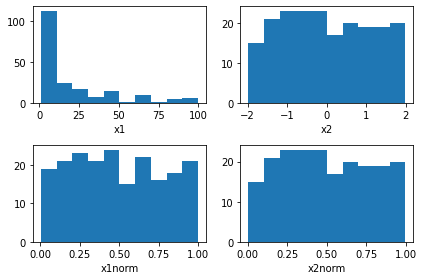

In [7]:
from scipy.stats import norm,uniform,loguniform
X,Xnorm = gpo.create_Xgrid(200)

plt.subplot(2,2,1)
plt.hist(X[:,0])
plt.xlabel(gpo.dims[0]['name'])

plt.subplot(2,2,2)
plt.hist(X[:,1])
plt.xlabel(gpo.dims[1]['name'])

plt.subplot(2,2,3)
plt.hist(Xnorm[:,0])
plt.xlabel(gpo.dims[0]['name']+'norm')

plt.subplot(2,2,4)
plt.hist(Xnorm[:,1])
plt.xlabel(gpo.dims[1]['name']+'norm')

plt.tight_layout()

0.00316**2 * RBF(length_scale=0.117)

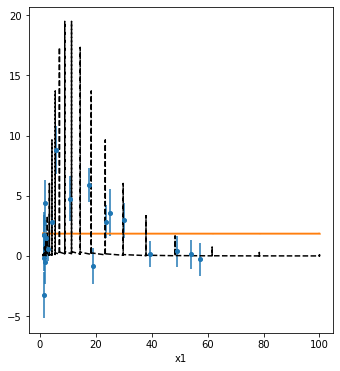

In [8]:
X_test = gpo.uniform_Xgrid(20)
y_test,std_test = gpo.predict(X_test)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.errorbar(gpo.X[:,0],gpo.y,gpo.yerr,linestyle='',marker='o',markersize=4)
plt.plot(X_test[:,0],y_test,color='tab:orange')
plt.fill_between(X_test[:,0].ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5,color='tab:orange')
plt.plot(X_test[:,0],fun0(X_test),'k--')
plt.xlabel(gpo.dims[0]['name'])

#plt.subplot(1,2,2)
#plt.scatter(gpo.X[:,1],gpo.y)
#plt.plot(X_test[:,1],y_test)
#plt.fill_between(X_test[:,1].ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
#plt.plot(X_test[:,1],fun0(X_test),'k--')
#plt.xlabel(gpo.dims[1]['name'])

gpo.gaussian_process.kernel_

0.00316**2 * RBF(length_scale=0.117)

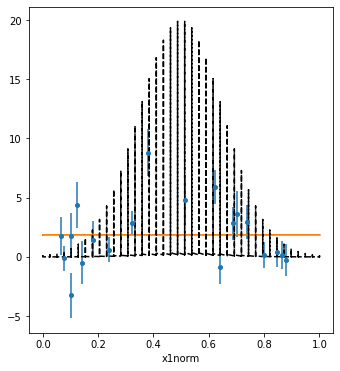

In [9]:
X_test = gpo.uniform_Xgrid(40)
y_test,std_test = gpo.predict(X_test)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.errorbar(gpo.Xnorm[:,0],gpo.y,gpo.yerr,linestyle='',marker='o',markersize=4)
plt.plot(gpo.X_to_Xnorm(X_test)[:,0],y_test,color='tab:orange')
plt.fill_between(gpo.X_to_Xnorm(X_test)[:,0].ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5,color='tab:orange')
plt.plot(gpo.X_to_Xnorm(X_test)[:,0],fun0(X_test),'k--')
plt.xlabel(gpo.dims[0]['name'] + 'norm')

#plt.subplot(1,2,2)
#plt.scatter(gpo.X[:,1],gpo.y)
#plt.plot(X_test[:,1],y_test)
#plt.fill_between(X_test[:,1].ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
#plt.plot(X_test[:,1],fun0(X_test),'k--')
#plt.xlabel(gpo.dims[1]['name'])

gpo.gaussian_process.kernel_

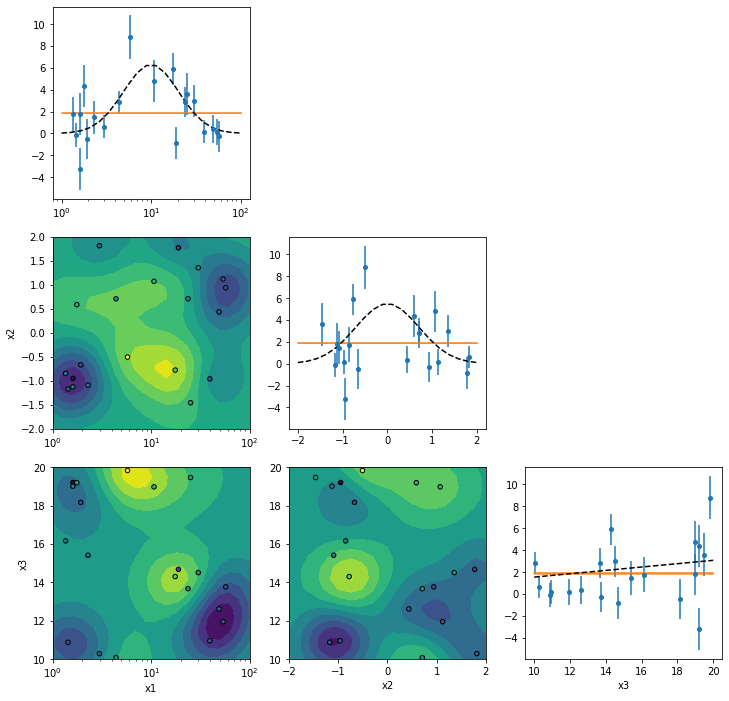

In [10]:
n = 20
axs = gpo.mean_slices_plot(n)

l = len(gpo.dims)
for i in range(l):
    ms = gpo.mean_predict(i,n,fun=fun0)
    axs[i,i].plot(ms[i+2],ms[0],'k--')

[array([[12.26870561,  1.25007948, 17.98187618]]),
 array([[15.43140029, -1.22490067, 19.66023505]])]

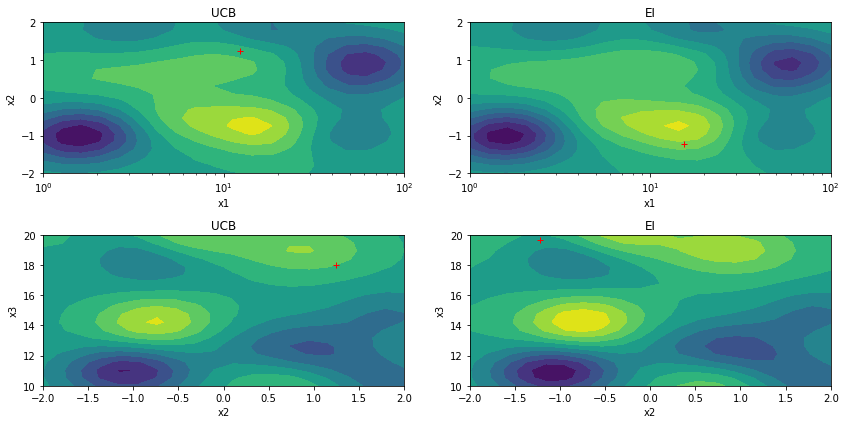

In [11]:
n = 20

nxt1norm = gpo.next_acquisition(Nacq=10,explore=1,acq_fn='UCB')
nxt2norm = gpo.next_acquisition(Nacq=10,explore=0.01,acq_fn='EI')
nxt1 = gpo.Xnorm_to_X(nxt1norm)
nxt2 = gpo.Xnorm_to_X(nxt2norm)

ms = gpo.mean_predict((0,1),n,fun=lambda X:gpo.acquisition_function(gpo.X_to_Xnorm(X),explore=1,acq_fn='UCB'))

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.contourf(ms[2],ms[3],ms[0],levels=int(n/2))
plt.plot(nxt1[:,0],nxt1[:,1],'+',color='r')
plt.xscale('log')
plt.xlabel(gpo.dims[0]['name'])
plt.ylabel(gpo.dims[1]['name'])
plt.title('UCB')

ms = gpo.mean_predict((0,1),n,fun=lambda X:gpo.acquisition_function(gpo.X_to_Xnorm(X),explore=0.01,acq_fn='EI'))

plt.subplot(2,2,2)
plt.contourf(ms[2],ms[3],ms[0],levels=int(n/2))
plt.plot(nxt2[:,0],nxt2[:,1],'+',color='r')
plt.xscale('log')
plt.xlabel(gpo.dims[0]['name'])
plt.ylabel(gpo.dims[1]['name'])
plt.title('EI')
plt.tight_layout()

ms = gpo.mean_predict((1,2),n,fun=lambda X:gpo.acquisition_function(gpo.X_to_Xnorm(X),explore=1,acq_fn='UCB'))

plt.subplot(2,2,3)
plt.contourf(ms[3],ms[4],ms[0],levels=int(n/2))
plt.plot(nxt1[:,1],nxt1[:,2],'+',color='r')
plt.xlabel(gpo.dims[1]['name'])
plt.ylabel(gpo.dims[2]['name'])
plt.title('UCB')

ms = gpo.mean_predict((1,2),n,fun=lambda X:gpo.acquisition_function(gpo.X_to_Xnorm(X),explore=0.01,acq_fn='EI'))

plt.subplot(2,2,4)
plt.contourf(ms[3],ms[4],ms[0],levels=int(n/2))
plt.plot(nxt2[:,1],nxt2[:,2],'+',color='r')
plt.xlabel(gpo.dims[1]['name'])
plt.ylabel(gpo.dims[2]['name'])
plt.title('EI')
plt.tight_layout()

[nxt1,nxt2]


In [20]:
N_new = 20
gpo.optimise(N_new,Nacq=10,explore=10,acq_fn='UCB')

Current maximum:  [ 9.77243851  0.06572432 20.        ]  giving  23.540282205435172 +- 2.0
Next acquisition:  [100.   2.  20.]


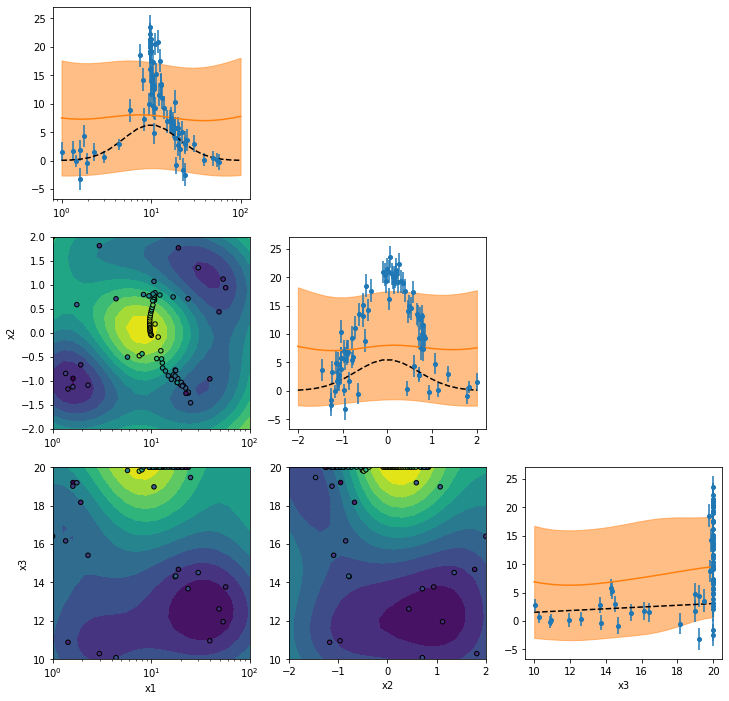

In [21]:
n = 20
axs = gpo.mean_slices_plot(n)

l = len(gpo.dims)
for i in range(l):
    ms = gpo.mean_predict(i,n,fun=fun0)
    axs[i,i].plot(ms[i+2],ms[0],'k--')

i_max = np.argmax(gpo.y)
X_max = gpo.Xnorm_to_X(gpo.Xnorm[i_max,:].reshape(1,-1))
y_max = gpo.y[i_max]
yerr_max = gpo.yerr[i_max]
print('Current maximum: ', X_max[0],' giving ',y_max,'+-',yerr_max)
print('Next acquisition: ', gpo.Xnorm_to_X(gpo.next_acquisition(Nacq=10,explore=10,acq_fn='UCB')).reshape(1,-1)[0])